In [1]:
import pandas as pd
import numpy as np
import sklearn
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import gaussian 
from skimage import filters, io
import os, shutil
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from osgeo import ogr, gdal, osr
import cv2

In [2]:
os.chdir("C:/Users/liang/Desktop/idTrees/Data2020/DL_nv")

In [3]:
files = os.listdir()
tifs = [i for i in files if i.endswith('.tif')]
print(tifs[0:5])
len(tifs)

['MLBS_1.tif', 'MLBS_10.tif', 'MLBS_11.tif', 'MLBS_12.tif', 'MLBS_13.tif']


85

(200, 200, 9)


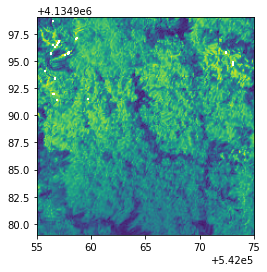

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4e+38,
 'width': 200,
 'height': 200,
 'count': 9,
 'crs': CRS.from_epsg(32617),
 'transform': Affine(0.1, 0.0, 542055.0,
        0.0, -0.1, 4134999.0)}

In [4]:
raA = rio.open('./MLBS_1.tif')
arys = raA.read()
arys = arys.astype('uint8')
arys2 = np.moveaxis(arys, 0, -1)
print(arys2.shape)

show(raA)
raA.meta

In [5]:
ts = raA.meta.copy()
print(ts)
ts.update({'nodata':-99.0, 'count':1})
print(ts)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 200, 'height': 200, 'count': 9, 'crs': CRS.from_epsg(32617), 'transform': Affine(0.1, 0.0, 542055.0,
       0.0, -0.1, 4134999.0)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99.0, 'width': 200, 'height': 200, 'count': 1, 'crs': CRS.from_epsg(32617), 'transform': Affine(0.1, 0.0, 542055.0,
       0.0, -0.1, 4134999.0)}


## Define function to read tif images and return image arrays

In [6]:
def ra2ar(ra_nm):
    ra = rio.open(ra_nm)
    arys = ra.read()
    arys = arys.astype('uint8')
    arys2 = np.moveaxis(arys, 0, -1)
    rgb = arys2[:,:,0:3]
    hsi = arys2[:,:,3:6]
    cp = arys2[:,:,6]
    cd = arys2[:,:,7]
    return rgb, hsi, cp, cd

## Define function to conduct image segmentation on different image arrays

In [7]:
def segAll2(rgb, hsi, cd, kernel_size1, max_dist1, ratio1, kernel_size2, max_dist2, ratio2):
  kernel_size = kernel_size1
  max_dist = max_dist1
  ratio = ratio1
  
  rgb_segs = quickshift(rgb, kernel_size=kernel_size1, convert2lab=False, max_dist= max_dist1, ratio= ratio1)
  hsi_segs = quickshift(hsi, kernel_size=kernel_size1, convert2lab=False, max_dist= max_dist1, ratio= ratio1)
  cd_segs = quickshift(cd, kernel_size=kernel_size1, convert2lab=False, max_dist= max_dist1, ratio= ratio1)

  all_segs = np.vstack([[rgb_segs], [hsi_segs],[cd_segs]])
  all_segs = np.moveaxis(all_segs, 0, -1)
  all_segs = all_segs.astype('uint8')

  final_segs2 = quickshift(all_segs, kernel_size = kernel_size2, convert2lab=False, max_dist= max_dist2, ratio= ratio2)


  return(rgb_segs, hsi_segs, cd_segs, final_segs2)

## Define function write Image arrays to geotiff image

In [8]:
def writeImg(img, img_template, nm):
  img = img.astype('int16')
  meta_tp = img_template.meta.copy()
  #meta.update({'nodata': 0, 'dtype': int8, 'count':1})
  meta_tp.update({'nodata': 999, 'dtype': 'int16', 'count':1})

  with rio.open(nm, 'w', **meta_tp) as outf:
    outf.write(img, 1)

## Define function to convert geotiff images to geopolygons

In [9]:
def ra2ply(img_nm):

  ply_nm = img_nm[0:-4]
  sourceRaster = gdal.Open(img_nm)
  srs = osr.SpatialReference()
  srs.ImportFromWkt(sourceRaster.GetProjection())
  band = sourceRaster.GetRasterBand(1)
  bandArray = band.ReadAsArray()
  outShapefile = ply_nm
  driver = ogr.GetDriverByName("ESRI Shapefile")
  
  if os.path.exists(outShapefile+".shp"):
    driver.DeleteDataSource(outShapefile+".shp")
  outDatasource = driver.CreateDataSource(outShapefile+ ".shp")
  outLayer = outDatasource.CreateLayer(ply_nm, srs=srs)
  newField = ogr.FieldDefn('MYFLD', ogr.OFTInteger)
  outLayer.CreateField(newField)
  
  gdal.Polygonize(band, band, outLayer, 0, [], callback=None )
  outDatasource.Destroy()
  sourceRaster = None

## Slightly modify functions to read geotiff into image arrays

In [10]:
def ra2ar(ra_nm):
    ra = rio.open(ra_nm)
    arys = ra.read()
    arys = arys.astype('uint8')
    arys2 = np.moveaxis(arys, 0, -1)
    
    #arys2 = gaussian(arys2, sigma=1)
    
    rgb = arys2[:,:,0:3]
    
    #gr = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    hsi = arys2[:,:,3:6]
    cp = arys2[:,:,6]
    #cd = arys2[:,:,7]
    nv = arys2[:,:,8]
    #tp = arys2[:,:,9]
    all_va = arys2[:,:,[0,1,2,6,8]]
    all_va2 = arys2[:,:,[0,1,2,3, 4, 5,6,8]]
    #all_va2 = arys2[:,:,[3,4, 5,8,9]]
    all_va3 = arys2[:,:,[6,8]]
    
    return rgb,hsi, cp,  nv, all_va, all_va2, all_va3

In [15]:
os.chdir("C:/Users/liang/Desktop/idTrees/Data2020/IDTREES_competition_test/task1/DL_nv")
#os.chdir("C:/Users/liang/Desktop/idTrees/Data2020/DL_nv_cm")
files = os.listdir()
tifs = [i for i in files if i.endswith('.tif')]
print(tifs[0:5])
len(tifs)

['MLBS_10.tif', 'MLBS_16.tif', 'MLBS_25.tif', 'MLBS_27.tif', 'MLBS_28.tif']


153

In [12]:
#os.mkdir('seg3_5')
#os.chdir('seg3')

In [418]:
for img in tifs:
    
    nm1 = "./seg3_5/"+ img[0:-4] + ".tif"

    rgb,hsi, cp,nv, all_va, all_va2, all_va3 = ra2ar(img)
    segs = quickshift(all_va2, kernel_size=5, convert2lab=False, max_dist= 100, ratio= 0.3) # k4
    raA = rio.open(img)

    writeImg(segs, raA, nm1)


In [419]:
os.chdir("seg3_5")
tifs2 = os.listdir()
tifs = [i for i in tifs2 if i.endswith('.tif')]
for tf in tifs:
    ra2ply(tf)

## Slightly modify functions to read geotiff into image arrays

In [32]:
def ra2ar(ra_nm):
    ra = rio.open(ra_nm)
    arys = ra.read()
    arys = arys.astype('uint8')
    arys2 = np.moveaxis(arys, 0, -1)
    #arys2 = gaussian(arys2, sigma=0.5)
        
    rgb = arys2[:,:,0:3]
    
    #gr = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    hsi = arys2[:,:,3:6]
    cp = arys2[:,:,6]
    cd = arys2[:,:,7]
    nv = arys2[:,:,8]
    all_va = arys2[:,:,[0,1,2,6,8]]
    all_va2 = arys2[:,:,[0,1,2,3, 4, 5,6,8]]
    all_va3 = arys2[:,:,[6,8]]
    
    rgb2 = rgb.astype('float32')
    hsi2 = hsi.astype('float32')
    #cp2 = gaussian(cp, sigma=8)
    
    gr = cv2.cvtColor(hsi2, cv2.COLOR_RGB2GRAY)
    edge_roberts = filters.roberts(gr)
    edge_sobel = filters.sobel(cp)
    
    return rgb,hsi, cp,  nv, all_va, all_va2, all_va3, edge_roberts

## Case studies to read geotiff into image arrays and visualize results

<Figure size 432x288 with 0 Axes>

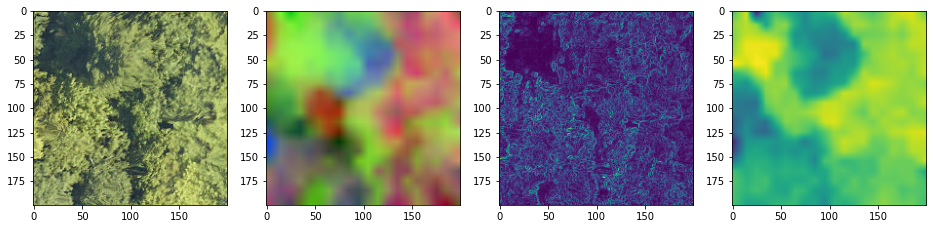

In [34]:
rgb, hsi, cp,  nv,  all_va, all_va2, all_va3, edge_roberts = ra2ar("MLBS_16.tif")

plt.figure()
f, axs = plt.subplots(1, 4, figsize=(16, 8)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axs[0].imshow(rgb)
axs[1].imshow(hsi)
axs[2].imshow(edge_sobel)
axs[3].imshow(nv)


## Case study to show a two-step segmentation

### Step 1 - conduction image segmentation and visualize segments

In [35]:
kernel_size = 5
max_dist =150
ratio = 0.5

rgb_segs = quickshift(rgb, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
hsi_segs = quickshift(hsi, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
nv_segs = quickshift(nv, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
#cd_segs = quickshift(all_va2, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
print(all_va2.shape)

(200, 200, 8)


<Figure size 432x288 with 0 Axes>

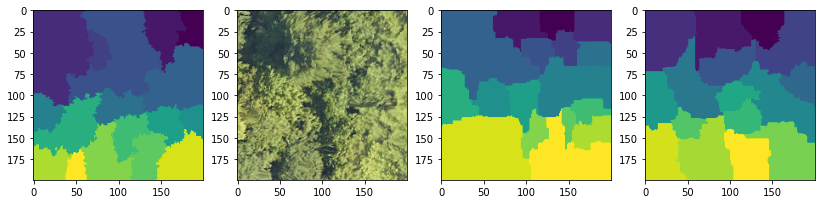

In [37]:
plt.figure()
f, axs = plt.subplots(1, 4,  figsize=(14, 6)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axs[0].imshow(rgb_segs)
axs[1].imshow(rgb)
axs[2].imshow(hsi_segs)
axs[3].imshow(nv_segs)

### Step 2 - Merge early several segmented images and conduct a final segmentation and visualize final segmented image

In [39]:
#all_segs = np.vstack([[rgb_segs], [hsi_segs],[cd]])
all_segs = np.vstack([[rgb_segs], [hsi_segs],[nv_segs]])
all_segs = np.moveaxis(all_segs, 0, -1)
all_segs = all_segs.astype('uint8')
print(all_segs.shape)

(200, 200, 3)


In [40]:
kernel_size = 6
max_dist =150
ratio = 0.5

final_segs = quickshift(all_segs, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)

<Figure size 432x288 with 0 Axes>

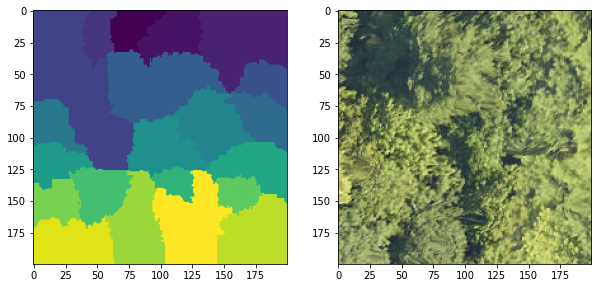

In [41]:
plt.figure()
f, axs = plt.subplots(1, 2,  figsize=(10, 6)) 
axs[0].imshow(final_segs)
axs[1].imshow(rgb)

## Write a loop to repeat the two-step segmentations over all images

In [42]:
os.chdir("C:/Users/liang/Desktop/idTrees/Data2020/IDTREES_competition_test/task1/DL_nv")
files = os.listdir()
tifs = [i for i in files if i.endswith('.tif')]
print(tifs[0:5])
len(tifs)

['MLBS_10.tif', 'MLBS_16.tif', 'MLBS_25.tif', 'MLBS_27.tif', 'MLBS_28.tif']


153

In [43]:
#os.mkdir('seg3_5')
#os.mkdir('segAll')

In [407]:
for img in tifs:
    
    nm1 = "./segAll/"+ img[0:-4] + ".tif"

    rgb,hsi, cp,  nv, tp, all_va, all_va2, all_va3 = ra2ar(img)
    segs = quickshift(all_va2, kernel_size=5, convert2lab=False, max_dist= 100, ratio= 0.3) # k4
    
    kernel_size = 5
    max_dist =150
    ratio = 0.5
    
    rgb_segs = quickshift(rgb, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
    hsi_segs = quickshift(hsi, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
    nv_segs = quickshift(nv, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
    
    all_segs = np.vstack([[rgb_segs], [hsi_segs],[tp],[nv_segs]])
    all_segs = np.moveaxis(all_segs, 0, -1)
    all_segs = all_segs.astype('uint8')
    
    kernel_size = 6
    max_dist =150
    ratio = 0.5
    final_segs = quickshift(all_segs, kernel_size=kernel_size, convert2lab=False, max_dist= max_dist, ratio= ratio)
    

    raA = rio.open(img)
    writeImg(final_segs, raA, nm1)
    

### Convert segmented images into polygon files

In [408]:
os.chdir("segAll")
tifs2 = os.listdir()
tifs = [i for i in tifs2 if i.endswith('.tif')]
for tf in tifs:
    ra2ply(tf)

## Resize images and write resized images

In [12]:
os.chdir("C:/Users/liang/Desktop/idTrees/Data2020/DL_nv/seg3_5/train/label")
tifs2 = os.listdir()
tifs = [i for i in tifs2 if i.endswith('.tif')]
len(tifs)

59

In [13]:
import matplotlib.pyplot as plt
from skimage import img_as_bool
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [503]:
for img in tifs:
    raA = rio.open(img)
    arys = raA.read(1)
    #arys = arys.astype('uint8')
    #arys2 = np.moveaxis(arys, 0, -1)
    img_re = img_as_bool(resize(arys, (256,256), anti_aliasing= True))
    #img_re = img_re*255
    #img_re = img_re.astype(np.uint8)
    #img_re = img_re[:, :, 0:3]
   
    #raA = rio.open(img)
    #writeImg(final_segs, raA, nm1)
    
    nm = './resize/'+ img[0:-3]+'png'
    io.imsave(nm, img_re)
    

C:\Users\liang\.conda\envs\geo_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: ./resize/MLBS_10.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\liang\.conda\envs\geo_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: ./resize/MLBS_11.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\liang\.conda\envs\geo_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: ./resize/MLBS_12.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\liang\.conda\envs\geo_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: ./resize/MLBS_13.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
C:\Users\liang\.conda\envs\geo_env\lib\site-

### Case show on resizing image

In [486]:
raA = rio.open(tifs[2])
arys = raA.read()
arys = arys.astype('uint8')
arys2 = np.moveaxis(arys, 0, -1)
img_re = resize(arys2, (256,256,4), anti_aliasing= True)
img_re = img_re.astype('uint8')


<Figure size 432x288 with 0 Axes>

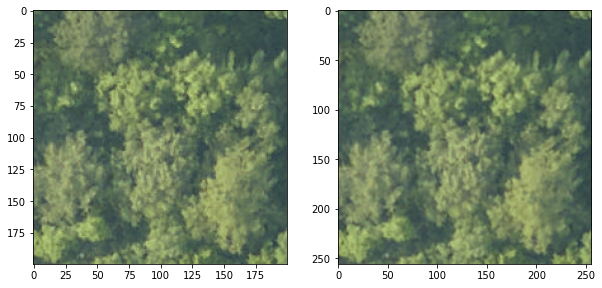

In [487]:
img_re = resize(arys2, (256,256,4), anti_aliasing= True)

plt.figure()
f, axs = plt.subplots(1, 2,  figsize=(10, 6)) 
axs[0].imshow(arys2[:,:,0:3])
axs[1].imshow(img_re[:,:,0:3])

In [14]:
os.chdir("C:/Users/liang/Desktop/idTrees/Data2020/DL_nv/seg3_5/train/resize/train/label")

## Edge detection and write detected edge images

In [448]:
for img in tifs:
    raA = rio.open(img)
    arys = raA.read(1)
    edge_roberts = filters.roberts(arys)
    bi = np.where(edge_roberts > 0, 0, 1)
    
    nm = "./bd/" + img
    
    writeImg(bi, raA, nm)

## Increase detected edge size and write the new edge image

In [532]:
from skimage.morphology import square
from skimage.morphology import erosion

files = os.listdir()
len(files)
files
os.mkdir('label')

for img in files:
    ra = io.imread(img)
    ts = erosion(ra,  square(3))
    
    nm = "./label/" + img
    io.imsave(nm, ts)

### Case show on edge detection

In [426]:
raA = rio.open('./MLBS_1.tif')
arys = raA.read(1)

edge_roberts = filters.roberts(arys)
edge_sobel = filters.sobel(arys)

<Figure size 432x288 with 0 Axes>

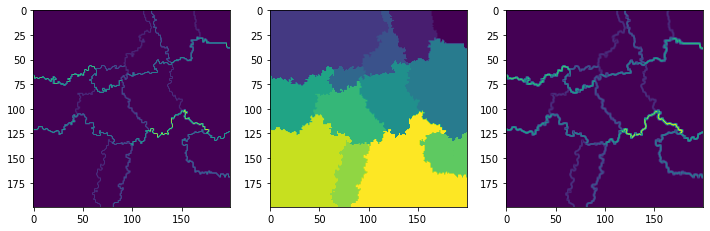

In [427]:
plt.figure()
f, axs = plt.subplots(1, 3,  figsize=(12, 6)) 
axs[0].imshow(edge_roberts)
axs[1].imshow(arys)
axs[2].imshow(edge_sobel)

### Change pixel values for edges and non-edges

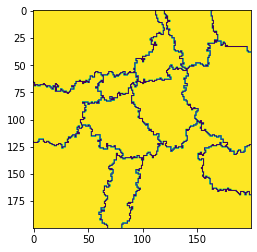

In [446]:
an_array = np.where(edge_roberts > 0, 0, 1)
#an_array = np.where(edge_sobel*10000 == 0, 1, 2)
plt.imshow(an_array)
#np.unique(edge_sobel)